In [81]:
import aifc # ReadAIFF

import math
import os
import time
import numpy as np
import pandas as pd

import mxnet as mx
from mxnet import nd, gluon, autograd
from mxnet.gluon import nn, rnn
ctx = mx.cpu(0)

import matplotlib.pyplot as plt
# from matplotlib import mlab
# import matplotlib

%matplotlib inline



In [2]:
# Set path to directory with folders train and test
path_data = '/Users/HONG_Mac/Desktop/whale_sound_analysis/'

##### Whale Sound Data

In [3]:
# ReadAIFF function
def ReadAIFF(file):
# Reads the frames from the audio clip and returns the uncompressed data
    s = aifc.open(file,'r')
    nFrames = s.getnframes()
    strSig = s.readframes(nFrames)
    return np.fromstring(strSig, np.short).byteswap()


In [4]:
# AIFF Data
s = ReadAIFF(path_data + 'train/train6.aiff')
pd.DataFrame(s).T

# 결과: 2000Hz의 2초 사운드 클립마다 프레임의 채널에서 압축되지 않은 샘플의 4000개 진폭값

,0,1,2,3,4,5,6,7,8,9,...,3990,3991,3992,3993,3994,3995,3996,3997,3998,3999
0,42,-486,-22,190,-102,-36,0,-45,-194,194,...,-221,-99,523,185,-414,-324,203,219,-155,-32


In [5]:
# Label Data
!head train.csv

clip_name,label
train1.aiff,0
train2.aiff,0
train3.aiff,0
train4.aiff,0
train5.aiff,0
train6.aiff,1
train7.aiff,1
train8.aiff,0
train9.aiff,1


##### Load Data

In [100]:
import csv
import random

train_label = []
train_sound = []

valid_label = []
valid_sound = []

valid_frac = 0.3

f = open('train.csv', 'r')
rdr = csv.reader(f)
skip_header = next(rdr)
for line in rdr:
    s = ReadAIFF(path_data + 'train/' + line[0])
    if random.random() > valid_frac:
        train_label.append(line[1])
        train_sound.append(list(s))
    else:
        valid_label.append(line[1])
        valid_sound.append(list(s))

f.close()

In [102]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
train_sound = scaler.fit_transform(pd.DataFrame(np.array(train_sound)))
valid_sound = scaler.fit_transform(pd.DataFrame(np.array(valid_sound)))

In [103]:
train_label = mx.nd.array(train_label)
train_sound = mx.nd.array(train_sound)
valid_label = mx.nd.array(valid_label)
valid_sound = mx.nd.array(valid_sound)

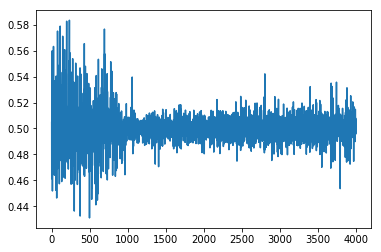

In [104]:
plt.plot(train_sound[0].asnumpy())

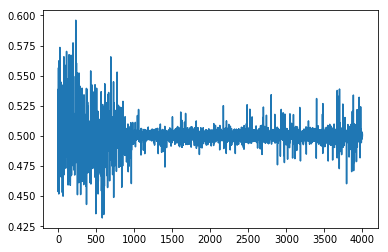

In [105]:
plt.plot(train_sound[6].asnumpy())

In [8]:
print("train_label.shape", train_label.shape)
print("train_sound.shape", train_sound.shape)
print("valid_label.shape", valid_label.shape)
print("valid_sound.shape", valid_sound.shape)

train_label.shape (21060,)
train_sound.shape (21060, 4000)
valid_label.shape (8940,)
valid_sound.shape (8940, 4000)


In [ ]:
def one_hot_encode(label):
    n_label = len(label)
    n_unique_label = len(np.unique(label.asnumpy()))
    res = nd.zeros((n_label, n_unique_label), ctx=ctx)
    res[nd.arange(n_label), label] = 1.0
    #for i, idx in enumerate(label):
    #    res[i, idx] = 1.0
    return res

In [51]:
train_label = one_hot_encode(train_label)
valid_label = one_hot_encode(valid_label)

##### Comprehension of GRU Block

In [52]:
layer = mx.gluon.rnn.GRU(2, 3) # (num_hidden, num_layers)
layer.initialize()
print('layer', layer)

# GRU INPUT 1 : DATA
input = mx.nd.random.uniform(shape=(5, 1, 10)) # (sequence_length, batch_size, feature_dims)
print("input.shape", input.shape)

# layout (str, default 'TNC') – The format of input and output tensors.
# T, N and C stand for sequence length, batch size, and feature dimensions respectively.

# Expected OUTPUT Shape: (5, 1, 2) # (sequence_length, batch_size, feature_dims)
# Expected RECURRENT STATE Shape: (1, 2, 3) # (num_layers, batch_size, num_hidden)

layer GRU(None -> 6, TNC, num_layers=3)
input.shape (5, 1, 10)


In [53]:
# Manually specify begin state.

# GRU INPUT 2 (Optional) : STATES
h0 = mx.nd.random.uniform(shape=(3, 1, 2)) # (num_layers, batch_size, num_hidden)
output, hn = layer(input, h0)
print("output.shape", output.shape)
print("hn[0].shape", hn[0].shape)

output.shape (5, 1, 2)
hn[0].shape (3, 1, 2)


In [54]:
# By default, zeros are used as begin state
# Same As h0 = nd.zeros(shape=(3, 1, 2)) 
output = layer(input)
print("output.shape", output.shape)

output.shape (5, 1, 2)


##### Comprehension of LSTM Block

In [55]:
layer = mx.gluon.rnn.LSTM(2, 3) # (num_hidden, num_layers)
layer.initialize()
print('layer', layer)

# LSTM INPUT 1 : DATA
input = mx.nd.random.uniform(shape=(5, 1, 10)) # (sequence_length, batch_size, feature_dims)
print("input.shape", input.shape)

# layout (str, default 'TNC') – The format of input and output tensors.
# T, N and C stand for sequence length, batch size, and feature dimensions respectively.

# Expected OUTPUT Shape: (5, 1, 2) # (sequence_length, batch_size, feature_dims)
# Expected RECURRENT STATE Shape: (1, 2, 3) # (num_layers, batch_size, num_hidden)

layer LSTM(None -> 8, TNC, num_layers=3)
input.shape (5, 1, 10)


In [56]:
# Manually specify begin state.

# LSTM INPUT 2 (Optional) : STATES
h0 = mx.nd.random.uniform(shape=(3, 1, 2)) # (num_layers, batch_size, num_hidden)
c0 = mx.nd.random.uniform(shape=(3, 1, 2)) # (num_layers, batch_size, num_hidden)
output, hn = layer(input, [h0, c0])
print("output.shape", output.shape)
print("hn[0].shape", hn[0].shape)

output.shape (5, 1, 2)
hn[0].shape (3, 1, 2)


In [57]:
# By default, zeros are used as begin state
# Same As h0 = nd.zeros(shape=(3, 1, 2)) 

output = layer(input)
print("output.shape", output.shape)

output.shape (5, 1, 2)


##### Model Block

In [58]:
class RNNModel(gluon.Block):
    """A model with an encoder, recurrent layer, and a decoder."""

    def __init__(self, mode, num_hidden, num_layers, dropout=0.5, bidirectional=False, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        with self.name_scope():
            self.drop = nn.Dropout(dropout)
            
            if mode == 'rnn_relu':
                self.rnn = rnn.RNN(num_hidden, num_layers, activation='relu', dropout=dropout, bidirectional=bidirectional)
                
            elif mode == 'rnn_tanh':
                self.rnn = rnn.RNN(num_hidden, num_layers, dropout=dropout, bidirectional=bidirectional)
                
            elif mode == 'lstm':
                self.rnn = rnn.LSTM(num_hidden, num_layers, dropout=dropout, bidirectional=bidirectional)
                
            elif mode == 'gru':
                self.rnn = rnn.GRU(num_hidden, num_layers, dropout=dropout, bidirectional=bidirectional)
                
            else:
                raise ValueError("Invalid mode %s. Options are rnn_relu, rnn_tanh, lstm, and gru"%mode)
                
            self.num_hidden = num_hidden
            
            self.flatten = nn.Flatten()
            self.dense = nn.Dense(10, activation="relu")
            self.pred  = nn.Dense(2)

    def forward(self, inputs, hidden):
        output, hidden = self.rnn(inputs, hidden)
        flatted = self.flatten(nd.transpose(output,(1,0,2)))
        densed = self.dense(flatted)
        preded = self.pred(densed)
        return preded, hidden
        #return output, hidden

    def begin_state(self, *args, **kwargs):
        return self.rnn.begin_state(*args, **kwargs)

In [59]:
args_model = 'rnn_relu'
args_batch_size = 1000
args_nhid = 5
args_nlayers = 2
args_lr = 1.0
args_clip = 0.2
args_epochs = 1
#args_bptt = 5
args_dropout = 0.2
args_log_interval = 3
args_save = 'model.param'
args_bidirect = False

In [66]:
model = RNNModel(args_model, args_nhid, args_nlayers, dropout=args_dropout, bidirectional=args_bidirect)
model.collect_params().initialize(mx.init.Xavier(), ctx=ctx)
print(model)

RNNModel(
  (drop): Dropout(p = 0.2)
  (rnn): RNN(None -> 5, TNC, num_layers=2, dropout=0.2)
  (flatten): Flatten
  (dense): Dense(None -> 10, Activation(relu))
  (pred): Dense(None -> 2, linear)
)


In [ ]:
trainer = gluon.Trainer(model.collect_params(), 'sgd', {'learning_rate': args_lr, 'momentum': 0, 'wd': 0})
loss = gluon.loss.SoftmaxCrossEntropyLoss()

In [67]:
trainer

In [62]:
# Starting each batch, we detach the hidden state from how it was previously produced.
# If we didn't, the model would try backpropagating all the way to start of the dataset.
# (참고) Why we need to detach variable which contains hidden representation
# https://discuss.pytorch.org/t/solved-why-we-need-to-detach-variable-which-contains-hidden-representation/1426

# NDArray.detach: Returns a new NDArray, detached from the current graph.
def detach(hidden):
    if isinstance(hidden, (tuple, list)):
        hidden = [i.detach() for i in hidden]
    else:
        hidden = hidden.detach()
    return hidden

In [63]:
def eval(data_source):
    total_L = 0.0
    ntotal = 0
    hidden = model.begin_state(func = mx.nd.zeros, batch_size = args_batch_size, ctx=ctx)
    for data, target in data_source:
        data = mx.nd.reshape(data, (data.shape[1], data.shape[0], 1))
        output, hidden = model(data, hidden)
        L = loss(output, target)
        total_L += mx.nd.sum(L).asscalar()
        ntotal += L.size
    return total_L / ntotal

In [64]:
def train():

    train_data = gluon.data.DataLoader(gluon.data.ArrayDataset(train_sound, train_label), batch_size=args_batch_size, shuffle=True)
    valid_data = gluon.data.DataLoader(gluon.data.ArrayDataset(valid_sound, valid_label), batch_size=args_batch_size, shuffle=True)

    for epoch in range(args_epochs):
        total_L = 0.0
        start_time = time.time()
        hidden = model.begin_state(func = mx.nd.zeros, batch_size = args_batch_size, ctx = ctx)
        for ibatch, data_and_target in enumerate(train_data):
            data, target = data_and_target
            
            hidden = detach(hidden)
            with autograd.record():
                data = mx.nd.reshape(data, (data.shape[1], data.shape[0], 1))
                output, hidden = model(data, hidden)
                L = loss(output, target)
                L.backward()

            grads = [i.grad(ctx) for i in model.collect_params().values()]
            # Here gradient is for the whole batch.
            # So we multiply max_norm by batch_size and bptt size to balance it.
            #gluon.utils.clip_global_norm(grads, args_clip * args_bptt * args_batch_size)
            gluon.utils.clip_global_norm(grads, args_clip * args_batch_size)

            trainer.step(args_batch_size)
            total_L += mx.nd.sum(L).asscalar()

            if ibatch % args_log_interval == 0 and ibatch > 0:
                cur_L = total_L / args_batch_size / args_log_interval
                print('[Epoch %d Batch %d] loss %.2f, perplexity %.2f' % (
                    epoch + 1, ibatch, cur_L, math.exp(cur_L)))
                total_L = 0.0

        val_L = eval(val_data)

        print('[Epoch %d] time cost %.2fs, validation loss %.2f, validation perplexity %.2f' % (
            epoch + 1, time.time() - start_time, val_L, math.exp(val_L)))


In [65]:
train()

MXNetError: Shape inconsistent, Provided=[1000,2], inferred shape=[1000,1]